# **Sales and Demand Forecasting**

## **Setup**

In [25]:
import pandas as pd
import numpy as np
from random import gauss, shuffle
import os, warnings, gc, copy, itertools, subprocess
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox

from sklearn.metrics import mean_absolute_percentage_error as mape, mean_squared_error as mse
from scipy.stats import shapiro, probplot
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.cluster import KMeans

import lightgbm as lgb
from gensim.models import Word2Vec # requires scipy<1.3 due to deprecation of lin. alg. funcs.

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [58]:
# Setup
data = 'data/'

class CFG:
    img_dim1 = 10
    img_dim2 = 6
    fontsize = 8
    marker = 1.5
    lines = 1.3

# plt.rcParams.keys() to list params
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2),
                     'font.size': (CFG.fontsize),
                     'lines.markersize': (CFG.marker),
                     'lines.linewidth': (CFG.lines)})   

In [55]:
# Func to calculate RMSE
def rmse(x, y):
    return (np.round(np.sqrt(mse(x, y)), 4))

In [14]:
# Get data from kaggle
from pathlib import Path
import zipfile
cred_path = Path('~/.kaggle/kaggle.json').expanduser()

def download_data(dataset, path, comp_check=True):
    os.makedirs(path, exist_ok=True)
    if any(Path(path).glob("*.zip")) or any(Path(path).iterdir()):
        print(f"Files already exist in '{path}'. Skipping download.")
        return
    if comp_check: kaggle_call = f"kaggle competitions download -c {dataset} -p {path}"
    else         : kaggle_call = f"kaggle datasets download -d {dataset} -p {path} --unzip"
    subprocess.run(kaggle_call, shell=True, check=True)
    for file in Path(path).glob("*.zip"):
        with zipfile.ZipFile(file, 'r') as zip_ref:
            zip_ref.extractall(path)
        print(f"Extracted {file}")
        file.unlink()
    print(f"Dataset '{dataset}' has been downloaded to '{path}'")

In [15]:
# Download M5 data
dataset = "m5-forecasting-accuracy"
download_path = "data/sales-forecasting/m5/"

download_data(dataset, download_path)

Files already exist in 'data/sales-forecasting/m5/'. Skipping download.


In [16]:
# Download secondary data
dataset = "konradb/partial-visuelle"
download_path = "data/sales-forecasting/partial-visuelle/"

download_data(dataset, download_path, comp_check=False)

Files already exist in 'data/sales-forecasting/partial-visuelle/'. Skipping download.


## **Data**

We will be working with data from the M5 competition titled ["M5 Forecasting Accuracy"](https://www.kaggle.com/c/m5-forecasting-accuracy).

>  The contest used a hierarchical sales data from Walmart to forecast daily sales for the next 28 days. From the comp description page: "The data covers stores in three US States (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price, promotions, day of the week, and special events".

In [38]:
# Load data from one state and format 
xdat = pd.read_csv('data/sales-forecasting/m5/sales_train_validation.csv')
xdat = xdat.loc[xdat.state_id == 'CA']
xdat.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


We need to be able to optimize how data is processed and modified in the parent dataframe in order to reduce memory usage.

In [39]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of the dataframe is {start_mem:.2f} MB")

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object and not pd.api.types.is_categorical_dtype(df[col]):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int16)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    
    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization is {end_mem:.2f} MB')
    print(f'Memory usage decreased by {((start_mem - end_mem) / start_mem)*100:.2f}%')
    return df

In [40]:
xdat = reduce_mem_usage(xdat)

Memory usage of the dataframe is 178.65 MB
Memory usage after optimization is 35.74 MB
Memory usage decreased by 79.99%


In [41]:
# Melt data into long format
xdat = pd.melt(xdat, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
               var_name='d', value_name='sales').dropna()

In [42]:
xdat.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [43]:
xdat.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
23330943,FOODS_3_823_CA_4_validation,FOODS_3_823,FOODS_3,FOODS,CA_4,CA,d_1913,0
23330944,FOODS_3_824_CA_4_validation,FOODS_3_824,FOODS_3,FOODS,CA_4,CA,d_1913,1
23330945,FOODS_3_825_CA_4_validation,FOODS_3_825,FOODS_3,FOODS,CA_4,CA,d_1913,0
23330946,FOODS_3_826_CA_4_validation,FOODS_3_826,FOODS_3,FOODS,CA_4,CA,d_1913,4
23330947,FOODS_3_827_CA_4_validation,FOODS_3_827,FOODS_3,FOODS,CA_4,CA,d_1913,8


In [44]:
# Get proper timestamps
xcal = pd.read_csv('data/sales-forecasting/m5/calendar.csv')
# merge with primary
xdat = pd.merge(xdat, xcal, on='d', how='left')
# get rid of calendar data
del xcal

In [46]:
xdat.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0


In [47]:
to_drop = ['d', 'wm_yr_wk', 'weekday', 'month', 'year', 'event_name_1', 'event_type_1',
           'event_name_2', 'event_type_2', 'snap_TX', 'snap_WI', 'state_id']
xdat.drop(to_drop, axis=1, inplace=True)

xdat.head()

,id,item_id,dept_id,cat_id,store_id,sales,date,wday,snap_CA
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0


## **The Croston Model**

### The Basic Croston

A simple approach to predicting intermittent demand series is the Croston model, can be broken down into three steps:

- Evaluate the average demand level when there is a demand occurrence
- Evaluate the average time between two demand occurrences
- Forecast the demand as the demand level (when there is an occurrence) multiplied by the probability of having an occurrence.

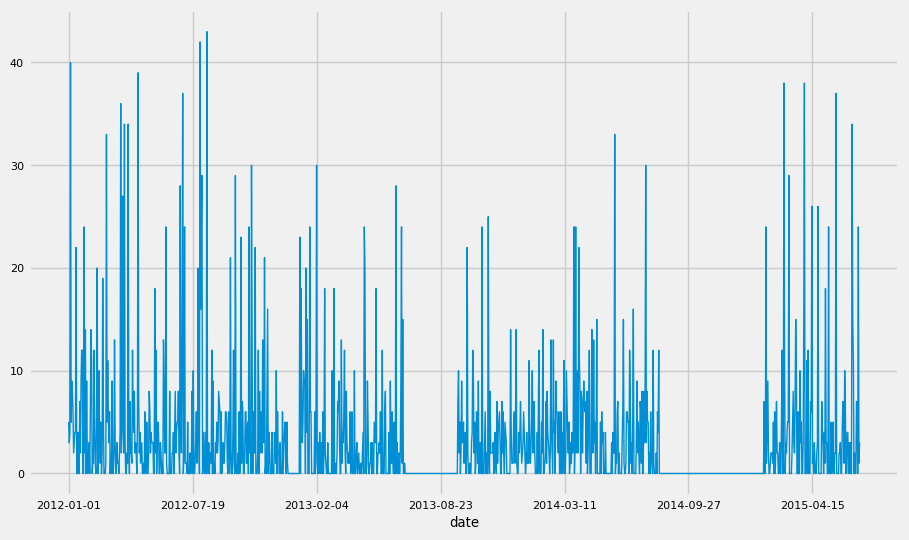

In [50]:
# Create a subset for single store and product combination
df = xdat.loc[(xdat.item_id == 'HOBBIES_1_288') & (xdat.store_id == 'CA_1')][['date', 'sales']].copy()
df = df.loc[(df.date >= '2012-01-01') & (df.date <= '2015-06-30')]
df.set_index('date').sales.plot();

The code for the basic Croston and the TSB variant is taken from:

- [Nicolas Vandeput's medium post **"Forecasting Intermittent Demand with the Croston Model"**](https://medium.com/towards-data-science/croston-forecast-model-for-intermittent-demand-360287a17f5f)

In [52]:
def Croston(ts, extra_periods=1, alpha=0.4):
    d = np.array(ts) #Transform the input into a numpy array
    cols = len(d) # Historical period length
    d = np.append(d, [np.nan]*extra_periods)# Append np.nan into the demand array to cover future periods
    
    # Level (a), Periodicity(p) and Forecast(f)
    a, p, f = np.full((3, cols+extra_periods), np.nan)
    q = 1 # Periods since last demand observation

    # Initialization
    first_occurence = np.argmax(d[:cols] > 0)
    a[0] = d[first_occurence]
    p[0] = 1 + first_occurence
    f[0] = a[0] / p[0]
    # Create t+1 forecasts
    for t in range(0, cols):
        if d[t] > 0:
            a[t+1] = alpha*d[t] + (1-alpha)*a[t]
            p[t+1] = alpha*q + (1-alpha)*p[t]
            f[t+1] = a[t+1] / p[t+1]
            q = 1
        else:
            a[t+1] = a[t]
            p[t+1] = p[t]
            f[t+1] = f[t]
            q += 1
    # Future forecasts 
    a[cols+1 : cols+extra_periods] = a[cols]
    p[cols+1 : cols+extra_periods] = p[cols]
    f[cols+1 : cols+extra_periods] = f[cols]

    df = pd.DataFrame.from_dict({"Demand": d, "Forecast": f, "Period": p, "Level": a, "Error": d-f})
    return df

In [53]:
# Generate a forecast with the algo above
pred_croston = Croston(df.sales, extra_periods=10)
pred_croston

,Demand,Forecast,Period,Level,Error
0,5.0,5.000000,1.000000,5.000000,0.000
1,3.0,5.000000,1.000000,5.000000,-2.000
2,4.0,4.200000,1.000000,4.200000,-0.200
3,40.0,4.120000,1.000000,4.120000,35.880
4,5.0,18.472000,1.000000,18.472000,-13.472
...,...,...,...,...,...
1282,NaN,5.050468,1.299267,6.561904,NaN
1283,NaN,5.050468,1.299267,6.561904,NaN
1284,NaN,5.050468,1.299267,6.561904,NaN
1285,NaN,5.050468,1.299267,6.561904,NaN


In [54]:
pred_croston.describe()

,Demand,Forecast,Period,Level,Error
count,1277.000000,1287.000000,1287.000000,1287.000000,1277.000000
mean,3.436179,4.631322,1.868924,6.790804,-1.191861
std,6.246256,2.707730,3.777975,3.304883,6.857931
min,0.000000,0.104706,1.000000,1.671525,-22.261815
25%,0.000000,2.906772,1.210377,4.325927,-5.086734
50%,1.000000,4.036516,1.445201,6.801083,-2.889425
75%,4.000000,5.115665,1.827808,7.409026,0.470709
max,43.000000,22.261815,68.867120,24.280725,38.878650


In [56]:
pred_croston = pred_croston.Forecast.head(len(df))
print('RMSE: ' + str(rmse(df.sales, pred_croston)))

RMSE: 6.9581


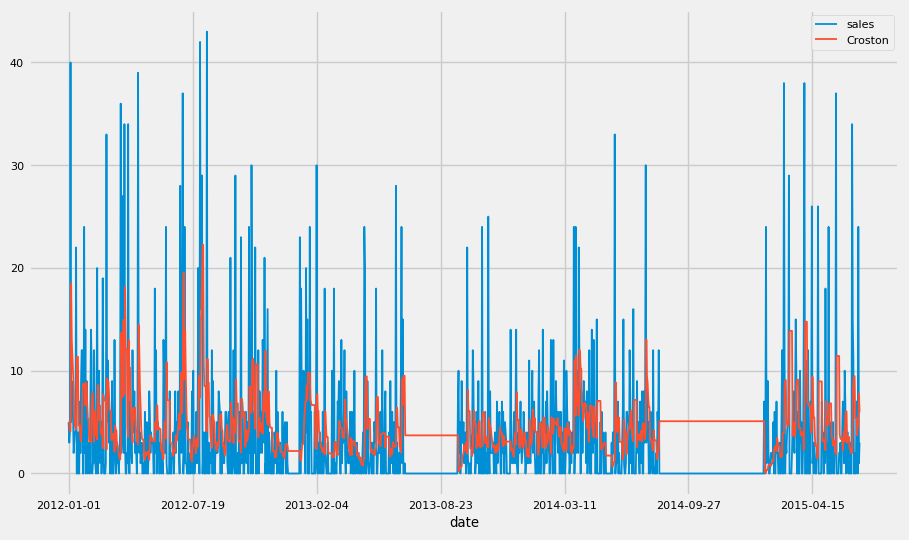

In [59]:
# Plot the forecast and actuals
df['Croston'] = pred_croston.values
df.set_index('date').plot();

The primary flaw with the basic form of the model is that forecasts are not updated during periods of no demand. So, in essence:
- extended periods with no demand ought to lead to a reduced forecast going forward.
- surges in demand after long periods of inactivity will not be captured accurately.

This model was improved in a 2011 publication titled ["Intermittent demand: Linking forecasting to inventory obsolescence"](https://www.sciencedirect.com/science/article/abs/pii/S0377221711004437), where a the model was allowed to decrease the periodicity estimate, even in the absence of demand.

Two key caveats are:

- the forecast `f` is defined as the periodicity `p` multiplied by the level `a` (and not divided by it, as in the original model)
- the forecast for `t+1` is defined based on the level and periodicity estimates of `t+1` (and not `t`).


In [66]:
def Croston_TSB(ts, extra_periods=1, alpha=0.4, beta=0.1):
    d = np.array(ts) #Transform the input into a numpy array
    cols = len(d) # Historical period length
    d = np.append(d, [np.nan]*extra_periods)# Append np.nan into the demand array to cover future periods
    
    # Level (a), Periodicity(p) and Forecast(f)
    a, p, f = np.full((3, cols+extra_periods), np.nan)
    
    # Initialization
    first_occurence = np.argmax(d[:cols] > 0)
    a[0] = d[first_occurence]
    p[0] = 1 / (1+first_occurence)
    f[0] = a[0] * p[0] # Change from the original model
    # Create t+1 forecasts
    for t in range(0, cols):
        if d[t] > 0:
            a[t+1] = alpha*d[t] + (1-alpha)*a[t]
            p[t+1] = beta*(1) + (1-beta)*p[t]
        else:
            a[t+1] = a[t]
            p[t+1] = (1-beta)*p[t]
        f[t+1] = p[t+1] * a[t+1]
    # Future forecasts 
    a[cols+1 : cols+extra_periods] = a[cols]
    p[cols+1 : cols+extra_periods] = p[cols]
    f[cols+1 : cols+extra_periods] = f[cols]

    df = pd.DataFrame.from_dict({"Demand": d, "Forecast": f, "Period": p, "Level": a, "Error": d-f})
    return df

In [67]:
# Fitting the data to the augmented model
pred_croston_tsb = Croston_TSB(df.sales, extra_periods=10, alpha=0.1, beta=0.1)

pred_croston_tsb = pred_croston_tsb.Forecast.head(len(df))
print('RMSE: ' + str(rmse(df.sales, pred_croston_tsb)))

RMSE: 6.1255
